<div class="alert alert-block alert-warning">

# <p style="text-align: center;">ECE4179 Assignment</p>
<div style="text-align: center;">
<img src="data/thumbnail.png" width="600"/>
</div>

Welcome to your assignment! This notebook contains all the code and comments that you need to submit. Here are the instructions to complete the assignment:

- Your grade is entirely based on notebook completion (no quiz).
- This assignment requires training deep learning models with large datasets which takes a while to complete. You are **highly encouraged** to start as soon as possible.
- After completing the notebook, submit it to Moodle under '**Assignment Submission**'. Along with this notebook, you have to submit your model file for Task 5 (similar to Lab 4). Further instructions can be found in Task 5.
- IMPORTANT: The notebook will be auto-graded, therefore please do not edit/rename the already-given variable/function/class names.

This assignment has five tasks:

- [Task 1: Linear and Logistic Regression](#task1)
- [Task 2: DAE: Denoising Autoencoder](#task2)
- [Task 3: Long Short-Term Memory (LSTM)](#task3)
- [Task 4: Movie Review Sentiment Analysis Using Pre-Trained Language Model (Transformer)](#task4)
- [Task 5: Design Your Own Regression Model](#task5)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision
from torchvision import transforms
from transformers import AutoTokenizer, AutoModel
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

def seed_all(seed=0):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

# if you intend to use GPU, you need to install PyTorch's CUDA support in the virtual environment:
# pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# GPU will be slightly quicker for training, but this assignment is tested and fully do-able with just cpu.

# import torch, platform, subprocess, sys, os
# print("torch:", torch.__version__, " built CUDA:", torch.version.cuda)
# print("is_available:", torch.cuda.is_available())
# print("device_count:", torch.cuda.device_count())
# print("py:", sys.executable)
# print("CUDA_VISIBLE_DEVICES:", os.getenv("CUDA_VISIBLE_DEVICES"))


c:\Users\dillo\Work_docs\ECE4179\ECE4179_Codes\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda


<div class="alert alert-block alert-info">

## Task 1 - Linear and Logistic Regression <a class="anchor" id="task1"></a>
        
You are probably thinking, these models again! Okay you are right, but there will be additional ideas presented here.
- You will apply nonlinear transformation to the dataset and perform regression/classification in the transformed space.
- You will explore the effects of outliers in your dataset and how that can affect your model performance. You will apply a weighted linear regression model so that the resulting model is more robust.
- You will train a model with a technique called learning rate decay.

<div class="alert alert-block alert-info">

### Task 1.1 - Iterative weighted linear regression <a class="anchor" id="t1_1"></a>

In some problems, every data point might not have the same importance. Having weights associated to samples will provide us with a principal way to model such problems. Consider a data set in which each data point $(\mathbf{x_i}, y_i)$, $\mathbf{x_i} \in \mathbb{R}^n$ (artificial neuron of 1 included), $y_i \in \mathbb{R}$ is associated with a weighting factor $0 < \alpha_i ≤ 1$. Define the loss of a linear model with parameters $\mathbf{w} \in \mathbb{R}^n$ as the weighted sum-of-squares error:

$$ \mathcal{L}_{\mathrm{wSE}}(\boldsymbol{w})=\frac{1}{m}\sum_{i=1}^{m}\alpha_i(\mathbf{w}^\top \mathbf{x_i} - y_i)^2 $$

It can be shown that the optimal weights can be obtained as: 

$$ \mathbf{w}^* = (X^\top A X)^{-1}X^\top A Y $$

Here, $X$ is a matrix of size $m × n$ where every row is one input sample (i.e., row $i$ in $X$ is $\mathbf{x_i}$). Similarly, $Y$ is an m dimensional vector storing $y_i$, and $A$ is a diagonal matrix of size $m × m$ with $A[i, i] = \alpha_i$. One way to compute the weighting factor is:

$$ \alpha_i = e^{(-\sigma(y_i^{noisy} - \hat{y_i})^2)} $$

where $\sigma$ is a hyperparemeter you can tune.

There are two sets of data, namely the training set $(X_\text{trn}, Y_\text{trn}^\text{noisy})$ and the validation/test set $(X_\text{val}, Y_\text{val})$. The purpose of this task is to train an iterative weighted linear regression model (using only the training data) that will weight the samples as the model is being trained, such that the final model can explain the validation data well (lower prediction error) compared to a vanilla linear regression model. You will implement the algorithm according to the following procedures:

<div style="text-align: center;">
<img src="data/weightedLR.png" width="700"/>
</div>

#### (a) Developing a generic function for (weighted) linear regression

In [335]:
# T1.1a IMPORTANT: Please do not edit/remove this comment.

def weighted_LS(X, Y, A=None):
    # This weighted least squares function can be used for both weighted least squares or a vanilla linear regression model.
    # The input "A" defaults to an identity matrix if None is passed, which would result in a vanilla linear regression model
    # The output will be the optimal weights
    # X: (n_samples, n_features), Y: (n_samples, 1), A: (n_samples, n_samples)
    # w: (n_features, 1)

    # If A is None, use identity matrix (vanilla linear regression)
    if A is None:
        A = np.eye(X.shape[0])
    
    # Compute w* = (X^T A X)^(-1) X^T A Y
    X_T_A = X.T @ A
    w = np.linalg.inv(X_T_A @ X) @ X_T_A @ Y

    return w  # Return optimal weight


def error_linear_model(X, w, Y):

    # Compute mean squared error: 1/m * ||Xw - Y||^2
    m = X.shape[0]
    predictions = X @ w
    error = (1 / m) * np.sum((predictions - Y) ** 2)
    
    return error

Load the data: _Task1_1.npz_

In [336]:
# Data has been loaded for you
data = np.load("data/Task1_1.npz")
X_trn = data["X_trn"]
Y_trn = data["Y_trn"]
X_val = data["X_val"]
Y_val = data["Y_val"]


print(X_trn.shape, Y_trn.shape, X_val.shape, Y_val.shape)

(30, 1) (30, 1) (10, 1) (10, 1)


#### (b) Visualise the train and validation data
Using a scatter plot, plot train data (X_trn, Y_trn) with red dots and validation data (X_val, Y_val) with blue dots, in the same plot. Remember to put title and x, y labels, legend for your plot.

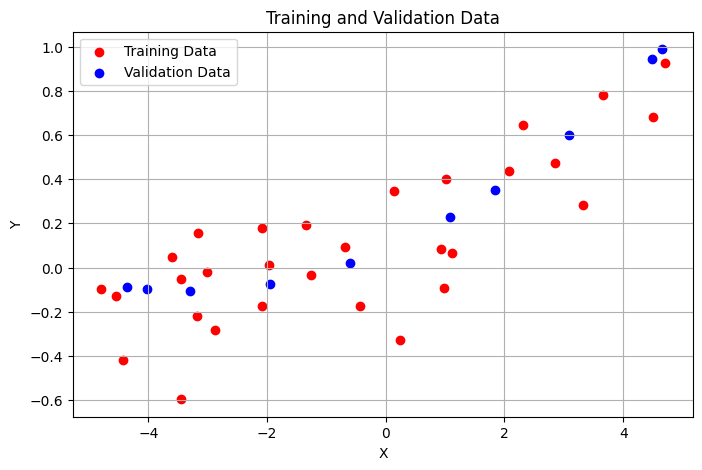

(30, 1) (30, 1) (10, 1) (10, 1)


In [337]:
# T1.1b IMPORTANT: Please do not edit/remove this comment.

# Visualise the data.
plt.figure(figsize=(8, 5))
plt.scatter(X_trn, Y_trn, color='red', label='Training Data')
plt.scatter(X_val, Y_val, color='blue', label='Validation Data')
plt.title('Training and Validation Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

print(X_trn.shape, Y_trn.shape, X_val.shape, Y_val.shape)


#### (c) Nonlinear Transformation of input data
The noise-free validation data indicates that the relationship is non-linear. Let's create non-linear features with the mapping: $ x_{aug} = [1, x, x^2, 1/x] $ for both train and validation data.

In [338]:
# T1.1c IMPORTANT: Please do not edit/remove this comment.

# Create non-linear features, do it for both train and validation data
# Make sure the shape of the augmented data is (n_samples, 4)
X_aug_trn = np.hstack([np.ones_like(X_trn), X_trn, X_trn**2, 1 / X_trn])
X_aug_val = np.hstack([np.ones_like(X_val), X_val, X_val**2, 1 / X_val])

#### (d) Iterative Weighted Linear Regression
Implement iterative weighted linear regression. You have to tune `sigma` and `max_iter` yourself. Store the optimal weight as the variable `w_optimal`.

In [339]:
# T1.1d IMPORTANT: Please do not edit/remove this comment.

# Iteratively fit the model according to the algorithm in Task 1 description
max_iter = 100
sigma = 1

A = np.eye(X_aug_trn.shape[0])  # Identity matrix
best_val_error = float('inf')
w_optimal = None  # placeholder

for num_iter in range(max_iter):
    # Step 1: Fit weighted least squares
    w = weighted_LS(X_aug_trn, Y_trn, A)

    # Step 2: Predict on training set
    Y_hat_trn_iter = X_aug_trn @ w

    # Step 3: Update weights (α_i)
    residuals = (Y_trn - Y_hat_trn_iter).flatten()
    alpha = np.exp(-sigma * residuals**2)

    # Step 4: Update A with new weights
    A = np.diag(alpha)

    # Step 5: Evaluate on validation set
    Y_hat_val = X_aug_val @ w
    val_error = error_linear_model(X_aug_val, w, Y_val)

    # Step 6: Keep best model based on validation error
    if val_error < best_val_error:
        best_val_error = val_error
        w_optimal = w

#### (e) Visualize Results
Now let's visualise the estimated **train data after being weighted** using `w_optimal`. In the same scatter plot, plot the original train samples in red (X_trn, Y_trn), and the weighted samples after passing them into the model in blue (X_trn, Y_hat_trn). As usual, include the necessary labels.

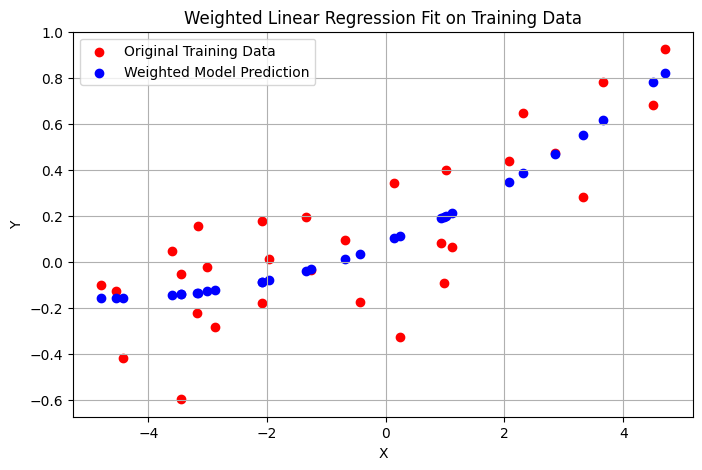

(30, 1) (30, 1) (30, 1)


In [340]:
# T1.1e IMPORTANT: Please do not edit/remove this comment.

Y_hat_trn = X_aug_trn @ w_optimal

# Plot original vs predicted
plt.figure(figsize=(8, 5))
plt.scatter(X_trn, Y_trn, color='red', label='Original Training Data')
plt.scatter(X_trn, Y_hat_trn, color='blue', label='Weighted Model Prediction')
plt.title('Weighted Linear Regression Fit on Training Data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.grid(True)
plt.show()

print(X_trn.shape, Y_trn.shape, Y_hat_trn.shape)


<div class="alert alert-block alert-info">
    
### Task 1.2 - Using non-linear features and learning rate decay for better classification <a class="anchor" id="t1_2"></a>

You have been given a set of samples $x = (x_1,x_2)^\top \in \mathbb{R}^2$. In this task, you will apply the knowledge you learned from Lab 2 to train a logistic model via Gradient Descent and try to improve the performance by implementing the decaying learning rate. You will implement the following steps:
- Copy some functions from Lab 2. The 3 functions you will need are: sigmoid(), predict(), compute_loss_and_grad()
- Load and visualise data
- Apply nonlinear transformation
- Train the model using GD
- Visualise the decision boundary
- Write a decaying learning rate function
- Train the model with decaying learning rate

Decaying learning rate can be simply implemented as $lr_\text{new}=(1-\alpha)\times lr_\text{old}$, where $0<\alpha<1$ is a hyperparameter. In this task, we use $\alpha = 0.1\%$ for the learning rate decay

#### (a) Copy the required functions from lab 2
The 3 functions required are: `sigmoid()`, `predict()`, and `compute_loss_and_grad()`

In [341]:
# T1.2a IMPORTANT: Please do not edit/remove this comment.

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def predict(X, w):

    # Input argument(s):
    # X - the input data (#samples, #input features)
    # w - the weights from the trained model (#samples, 1) 
     
    # Output:
    # Probability prediction of each data point (y_hat)

    # pass input data to x
    x =  X

    # Perform Matrix multiplication between the inputs and the weights
    z = x @ w

    # probability
    y_hat = sigmoid(z)

    return y_hat


def compute_loss_and_grad_old(X, y, y_hat):
    # Inputs:
    #    X - Set of samples (each sample is a row in X),
    #    y - Corresponding ground-truth labels
    #    y_hat - Predicted class probabilities

    # log(0) might throw error, so handled via small eps 
    eps = 1e-12

    # Compute the mean cross-entropy loss w.r.t. the parameters w (mean as defined in lecture)
    a = y * np.log(eps + y_hat)
    b = (1 - y) * np.log(1 + eps - y_hat)
    loss = np.mean(-(a + b))

    # Compute the gradient vector (mean over all samples as defined in lecture)
    # instead of using a loop, we can vectorised the operation, but need to ensure the final shape is correct
    grad_vec = np.matmul((y_hat - y).transpose(), X) / len(y)
    grad_vec = grad_vec.T # transpose to ensure the correct shape
    

    # Return loss and gradient vector
    return loss, grad_vec, grad_vec.shape

def compute_loss_and_grad(X, y, w):

    # Ensure y is column vector
    y = y.reshape(-1, 1)

    # Compute predictions
    y_hat = sigmoid(X @ w)

    # Prevent log(0)
    eps = 1e-12

    # Compute binary cross-entropy loss
    loss = -np.mean(y * np.log(y_hat + eps) + (1 - y) * np.log(1 - y_hat + eps))

    # Compute gradient
    grad = (X.T @ (y_hat - y)) / X.shape[0]

    return loss, grad


#### (b) Load and visualise data

In [342]:
# Load numpy dataset from Task1_2.npz. This has been done for you.
loaded_data_task4 = np.load("data/Task1_2.npz")

X_train = loaded_data_task4['arr_0']
X_test = loaded_data_task4['arr_1']
Y_train = loaded_data_task4['arr_2']
Y_test = loaded_data_task4['arr_3']

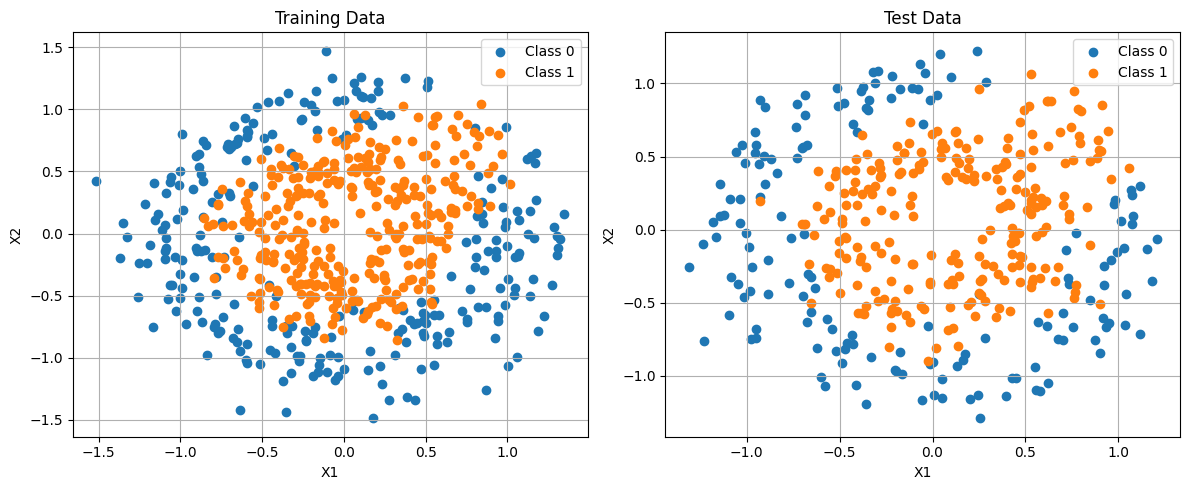

In [343]:
# T1.2b IMPORTANT: Please do not edit/remove this comment.

# Visualize non-linear features for both train and test data (similar to Lab 2)
# Create two plots side-by-side (Use subplots). Use scatter plots and show samples in different classes with different colours. The samples are 2-dimensional.

plt.figure(figsize=(12, 5))

# Plot training data
plt.subplot(1, 2, 1)
plt.title("Training Data")
for cls in np.unique(Y_train):
    idx = (Y_train.flatten() == cls)
    plt.scatter(X_train[idx, 0], X_train[idx, 1], label=f"Class {int(cls)}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)

# Plot test data
plt.subplot(1, 2, 2)
plt.title("Test Data")
for cls in np.unique(Y_test):
    idx = (Y_test.flatten() == cls)
    plt.scatter(X_test[idx, 0], X_test[idx, 1], label=f"Class {int(cls)}")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

#### (c) Apply nonlinear transformation

Let's map the samples (both train and test) with mapping $x_{aug}=[x_1, x_2, x_1^2, x_2^2, x_1x_2, 1]$

In [344]:
# T1.2c IMPORTANT: Please do not edit/remove this comment.

# Apply nonlinear mapping
X_trans_train = np.hstack([
    X_train,                         # x1, x2
    X_train[:, [0]]**2,              # x1^2
    X_train[:, [1]]**2,              # x2^2
    X_train[:, [0]] * X_train[:, [1]],  # x1 * x2
    np.ones((X_train.shape[0], 1))   # bias term
])

X_trans_test = np.hstack([
    X_test,
    X_test[:, [0]]**2,
    X_test[:, [1]]**2,
    X_test[:, [0]] * X_test[:, [1]],
    np.ones((X_test.shape[0], 1))
])


#### (d) Train the model using GD

In [345]:
# T1.2d IMPORTANT: Please do not edit/remove this comment.

# Set a random seed (Do not change!)
np.random.seed(0)
lr = 1.0  # Set the learning rate
num_epochs = 10000  # Train for 10000 epochs

loss = np.zeros(num_epochs)
theta = np.zeros((X_trans_train.shape[1], 1))  # Initialize theta with correct shape

for ep in range(num_epochs):
    # Compute loss and gradient
    loss[ep], grad = compute_loss_and_grad(X_trans_train, Y_train, theta)

    # Gradient descent update
    theta = theta - lr * grad

# Compute predicted probabilities
y_hat_train = predict(X_trans_train, theta)
y_hat_test = predict(X_trans_test, theta)

# Convert probabilities to class labels (0 or 1)
y_pred_train = (y_hat_train >= 0.5).astype(int)
y_pred_test = (y_hat_test >= 0.5).astype(int)

# Compute classification accuracy
acc_train = np.mean(y_pred_train == Y_train)
acc_test = np.mean(y_pred_test == Y_test)

print("Training accuracy: {:.3f}".format(acc_train))
print("Test accuracy: {:.3f}".format(acc_test))


Training accuracy: 0.893
Test accuracy: 0.910


#### (e) Visualise the Decision Boundary

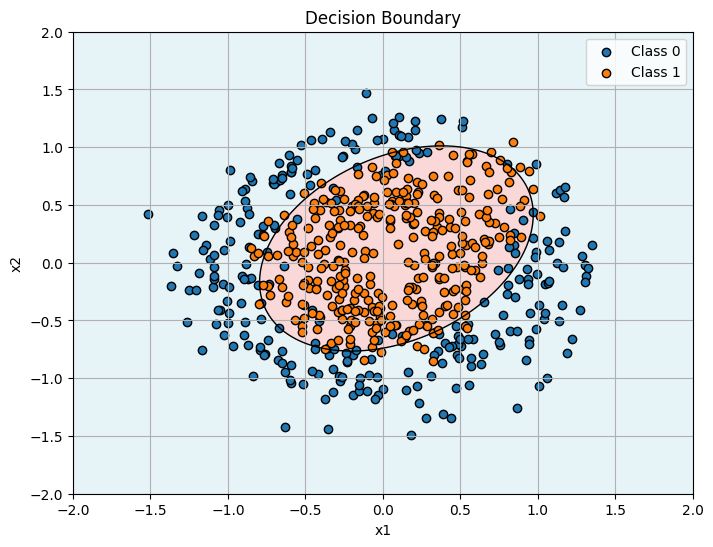

In [346]:
# T1.2e IMPORTANT: Please do not edit/remove this comment.

# Create a meshgrid for the input space
xx = np.linspace(-2, 2, 1000)
yy = np.linspace(-2, 2, 1000)
[X2, Y2] = np.meshgrid(xx, yy)

# Stack the features to match the same nonlinear transformation: [x1, x2, x1^2, x2^2, x1*x2, 1]
X_grid = np.c_[X2.ravel(), Y2.ravel()]  # shape: (1000000, 2)
X_grid_aug = np.hstack([
    X_grid,
    X_grid[:, [0]]**2,
    X_grid[:, [1]]**2,
    X_grid[:, [0]] * X_grid[:, [1]],
    np.ones((X_grid.shape[0], 1))
])

# Get predictions (probabilities)
Z = predict(X_grid_aug, theta)
Z = Z.reshape(X2.shape)

# Plot the decision boundary
plt.figure(figsize=(8, 6))
plt.contourf(X2, Y2, Z, levels=[0, 0.5, 1], colors=['lightblue', 'lightcoral'], alpha=0.3)
plt.contour(X2, Y2, Z, levels=[0.5], colors='black', linewidths=1)

# Overlay training data points
for cls in np.unique(Y_train):
    idx = (Y_train.flatten() == cls)
    plt.scatter(X_train[idx, 0], X_train[idx, 1], label=f"Class {int(cls)}", edgecolor='k')

plt.title("Decision Boundary")
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.grid(True)
plt.show()


#### (f) Write a decaying learning rate function

In [347]:
# T1.2f IMPORTANT: Please do not edit/remove this comment.

# Write a simple function to decrease current learning rate by 0.1%
def decaying_lr(lr):
    return lr * 0.999  # Reduce by 0.1%

#### (g) Train the model with decaying learning rate

In [348]:
# T1.2g IMPORTANT: Please do not edit/remove this comment.

# Set a random seed (Do not change!)
np.random.seed(0)
lr = 1.0  # Initial learning rate
num_epochs = 10000

loss = np.zeros(num_epochs)
theta = np.zeros((X_trans_train.shape[1], 1))  # Initialize theta

for ep in range(num_epochs):
    # Compute loss and gradient
    loss[ep], grad = compute_loss_and_grad(X_trans_train, Y_train, theta)

    # Gradient descent step
    theta -= lr * grad

    # Apply learning rate decay
    lr = decaying_lr(lr)

# Evaluate accuracy on training and test sets
y_hat_train = predict(X_trans_train, theta)
y_hat_test = predict(X_trans_test, theta)

y_pred_train = (y_hat_train >= 0.5).astype(int)
y_pred_test = (y_hat_test >= 0.5).astype(int)

acc_train_decay = np.mean(y_pred_train == Y_train)
acc_test_decay = np.mean(y_pred_test == Y_test)

print("Training accuracy: {:.3f}".format(acc_train_decay))
print("Test accuracy: {:.3f}".format(acc_test_decay))


Training accuracy: 0.897
Test accuracy: 0.915


<div class="alert alert-block alert-info">

## Task 2 - DAE: Denoising Autoencoder <a class="anchor" id="task2"></a>

In this task you will be training an **autoencoder** to denoise images.

An autoencoder (AE) is a neural network that learns to compress input data into a lower-dimensional latent space and then reconstruct the original data from that compressed form. It has two main parts: the encoder, which reduces the input into the latent space, and the decoder, which rebuilds the input from it. Crucially, the latent space is smaller than the input, forcing the network to capture only the most important features, not every detail.

This structure makes autoencoders effective for image denoising. A denoising autoencoder is trained with noisy images as input and their clean versions as targets. Since the network must pass the input through the bottleneck of the latent space, it learns to discard noise and retain key image structures. Once trained, it can clean up new noisy images by reconstructing them from their essential, noise-free features. The image below shows a denoising autoencoder in action:

<div style="text-align: center;">
<img src="data/denoising_ae.png" width="700">
</div>

<div class="alert alert-block alert-info">

### Task 2.1: Create dataloader for Face Data and visualise a few samples</a>

As usual, we first need to define the Dataset class and the dataloaders before we can train the model. Think about what are the inputs and labels for this task. The dataset for this task is located in `data/face_data.npy`, and it contains 1800 grayscale images (0-255), each with a shape of 64 x 64.

#### (a) Dataset class

In [349]:
# T2.1a IMPORTANT: Please do not edit/remove this comment.

# transform has been defined for you. No need to modify it.
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

class FaceData(Dataset):
    def __init__(self, transform=None):
        
        # Load the full dataset from the npy file.
        # We will split the dataset using another method later.
        self.data = np.load("data/face_data.npy")  # shape (1800, 64, 64)
        
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        
        image = self.data[idx].astype(np.uint8)  # ensure it's in image format (0-255 range)
        if self.transform is not None:
            image = self.transform(image)
        
        # Add gaussian noise to the image.
        # The noise needs to be scaled down (use a factor of 0.15) before added to the signal.
        # After adding the noise, clip the image to be between 0 and 1.
        noise = 0.15 * torch.randn_like(image)
        image_noisy = image + noise
        image_noisy = torch.clamp(image_noisy, 0., 1.)
        
        return image_noisy, image

#### (b) Create Dataset instance from the defined Class and then the DataLoaders

In [350]:
# T2.1b IMPORTANT: Please do not edit/remove this comment.

batch_size = 64

# We will use the random_split function (already imported for you) to split the dataset.
# First, instantiate the Dataset class with the full dataset.
# Then, apply random_split by passing the full dataset and the fractions of the split (the fractions should sum to 1).
# Use fractions that you think are appropriate for training, validation, and testing split
dataset_full = FaceData(transform=transform)

# Compute split lengths (e.g., 80% train, 10% val, 10% test)
total_len = len(dataset_full)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len  # ensure full coverage

dataset_train, dataset_val, dataset_test = random_split(dataset_full, [train_len, val_len, test_len])

# Create Dataloaders. They can have the same batch size, but only training data requires shuffling.
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

#### (c) Visualize the clean and noisy images

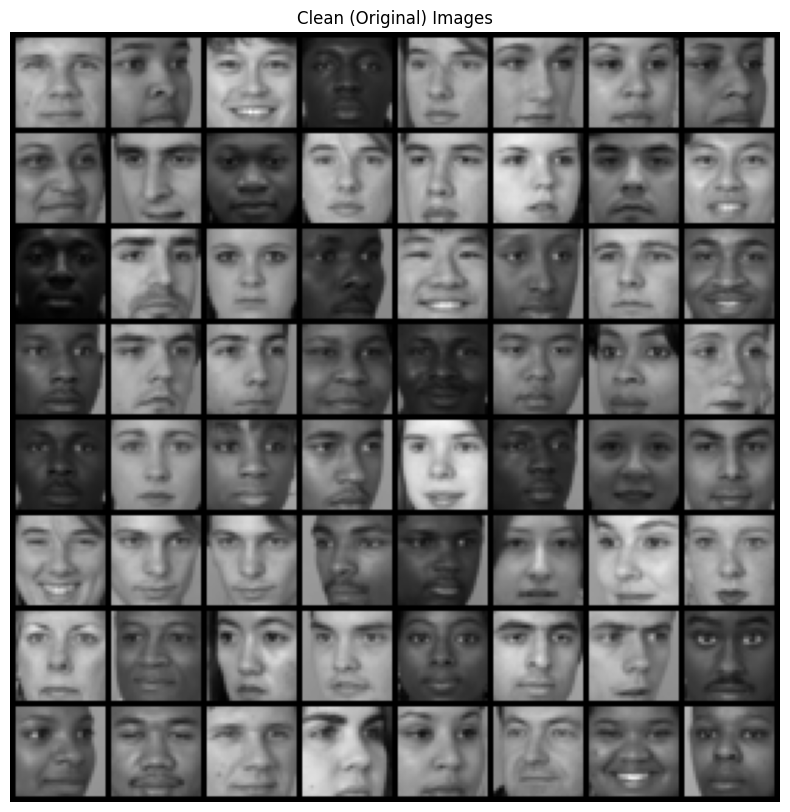

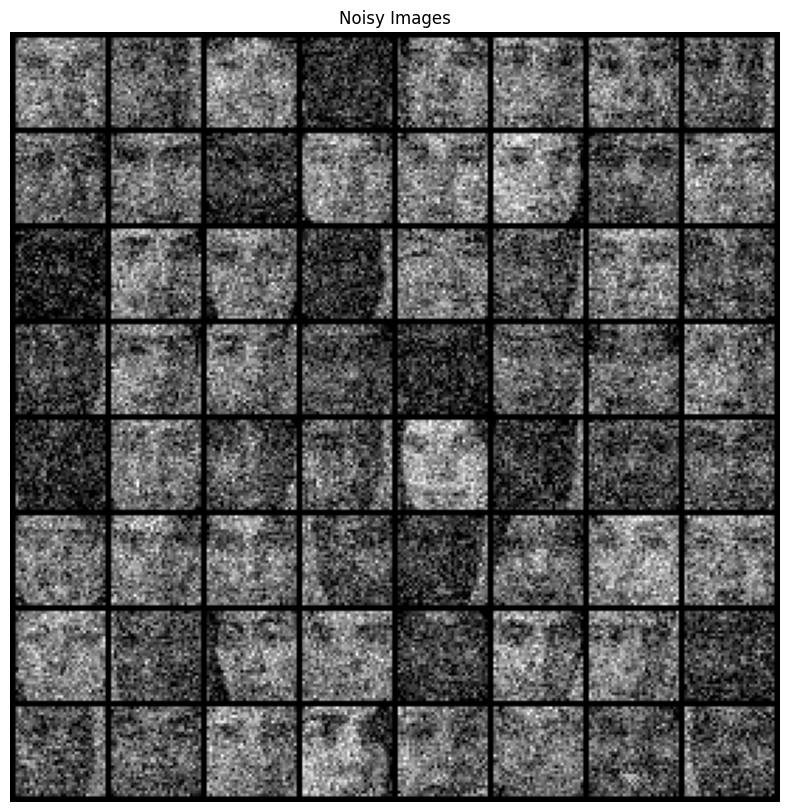

In [351]:
# T2.1c IMPORTANT: Please do not edit/remove this comment.

from torchvision.utils import make_grid

images_noisy, images = next(iter(loader_train))

# Function to display a grid of images
def show_images(tensor, title):
    grid = make_grid(tensor, nrow=8, normalize=True)
    np_img = grid.permute(1, 2, 0).cpu().numpy()
    plt.figure(figsize=(10, 10))
    plt.imshow(np_img, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Visualize clean/original images
show_images(images, title="Clean (Original) Images")

# Visualize noisy images
show_images(images_noisy, title="Noisy Images")

<div class="alert alert-block alert-info">
    
### Task 2.2: Design your network architecture for AE <a class="anchor" id="t2_2"></a>

In this task, you will create the model class `Simple_AE`. But first, you will create two separate classes `Encoder` and `Decoder` which defines the structure of the encoder-decoder modules, which you will then use within your `Simple_AE` class. This is another way to define deep learning model architecture in a more modular fashion, instead of defining everything in one single class.

The encoder will just consist of one layer with a LeakyReLU activation function. BatchNorm1d will also be added to the encoder to speed up convergence. The decoder will also be one layer with a sigmoid layer. You do not need to put a BatchNorm1d here.

_Note: A useful technique in speeding up training is using batch normalization (BatchNorm). To use BatchNorm1d, you simply have to put in the previous layer's number of input features as the input parameter. See the [PyTorch documentation](https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html) for more information._

#### (a) Encoder and Decoder class

In [352]:
# T2.2a IMPORTANT: Please do not edit/remove this comment.

class Encoder(nn.Module):    
    def __init__(self):
        super().__init__()
        
        # You will use one linear layer in the encoder class and pass it through BatchNorm1d() then LeakyReLU       
        self.encoder = nn.Sequential(
            nn.Flatten(), # first flatten the input image to a vector of size 32*32
            nn.Linear(1024, 128), # Add Linear Layer
            nn.BatchNorm1d(128), # Add BatchNorm1d() as the next one in the sequence. Note BatchNorm1d takes an input argument.
            nn.LeakyReLU(), # Then add LeakyReLU.
        )
        
    def forward(self, x):        
        
        return self.encoder(x)
    
class Decoder(nn.Module):   
    def __init__(self):
        super().__init__()
        
        # You will use one linear layer in the decoder class. No need for LeakyReLU because we have a sigmoid at the end
        self.decoder = nn.Sequential(
            nn.Linear(128, 1024), # Add Linear Layer
            nn.Sigmoid() # Sigmoid activation function to ensure the output is between 0 and 1
        )
        
    def forward(self, x):
        # After forward pass through your decoder, reshape the output to B x C x H x W before returning
        
        x = self.decoder(x)           # (B, 1024)
        x = x.view(-1, 1, 32, 32)     # reshape back to image
        
        return x

#### (b) Denoising autoencoder `Simple_AE` class

In [ ]:
# T2.2b IMPORTANT: Please do not edit/remove this comment.

class Simple_AE(nn.Module):
    def __init__(self, device='cpu'):
        super().__init__()
        self.device = device

        # Simple Encoder: Conv -> ReLU -> MaxPool
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=3, padding=1),  # (B, 1, 32, 32) -> (B, 8, 32, 32)
            nn.ReLU(),
            nn.MaxPool2d(2),                            # -> (B, 8, 16, 16)
            nn.Conv2d(8, 4, kernel_size=3, padding=1),  # -> (B, 4, 16, 16)
            nn.ReLU(),
            nn.MaxPool2d(2)                             # -> (B, 4, 8, 8)
        )

        # Simple Decoder: ConvTranspose -> ReLU
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(4, 8, kernel_size=2, stride=2),  # -> (B, 8, 16, 16)
            nn.ReLU(),
            nn.ConvTranspose2d(8, 1, kernel_size=2, stride=2),  # -> (B, 1, 32, 32)
            nn.Sigmoid()  # to output values in [0, 1]
        )

        self.to(device=self.device)

    def forward(self, x):
        # Forward pass through encoder and decoder
        x_encoded = self.encoder(x)
        x_decoded = self.decoder(x_encoded)
        return x_decoded
    
    def Train(self, epochs, optimizer, loader_train, loader_test, verbose=True):
        self.loss_train_log = []
        self.loss_test_log = []
        best_loss = np.inf
        criterion = nn.MSELoss(reduction='mean')

        for epoch in range(epochs):
            self.train()
            train_loss = 0.0

            # Step (1)        
            for x, y in loader_train:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float)

                optimizer.zero_grad()
                y_hat = self.forward(x)
                loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * x.size(0)

            train_loss /= len(loader_train.dataset)
            self.loss_train_log.append(train_loss)

            test_loss = self.evaluate(loader_test)
            self.loss_test_log.append(test_loss)

            if verbose:
                print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

            if test_loss < best_loss:
                best_loss = test_loss
                self.best_model = self.state_dict()   
        

    def evaluate(self, loader):
        # this function is to evaluate the model on a given dataset (loader) by computing the average loss

        self.eval()
        total_loss = 0.0
        criterion = nn.MSELoss(reduction='sum')
        
        loss = 0
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float)

                # forward pass and calculate loss
                # if reduction='sum' is used here, it will sum up all individual pixel loss. You can divide the loss by 1024 to get the average loss per image (32*32=1024)
                y_hat = self.forward(x)
                loss = criterion(y_hat, y)
                total_loss += loss.item()
        
        loss = total_loss / len(loader.dataset) / (32 * 32)  # average per image
        return loss
    
    def predict(self, loader):
        # this function is to provide the model's prediction (and the corresponding ground truth) on a given dataset (loader).
        
        self.eval()

        x_all, y_all, output = [], [], []
        with torch.no_grad():
            for x, y in loader:
                x_all += [x]
                y_all += [y]
                x = x.to(device=self.device, dtype=torch.float)

                # forward pass and store predictions
                y_hat = self.forward(x)
                output.append(y_hat.cpu())
            
            x_all = torch.cat(x_all, dim=0)
            y_all = torch.cat(y_all, dim=0)
            output = torch.cat(output, dim=0)
            return x_all, y_all, output 

<div class="alert alert-block alert-info">
    
### Task 2.3: Train your model and evaluate the DAE results

#### (a) Model training

Train your model with the following hyperparameters:
- Learning rate = \<use one that you think is good\>
- Number of epochs = 30
- Optimizer = Adam
- Weight decay = 1e-4 or 0.0001

In [354]:
# T2.3a IMPORTANT: Please do not edit/remove this comment.

lr = 1e-3
epochs = 30
model = Simple_AE(device=device)
# print(device)
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
model.Train(epochs, optimizer, loader_train, loader_val)

Epoch 0 | Train Loss: 0.0649 | Test Loss: 0.0568
Epoch 1 | Train Loss: 0.0607 | Test Loss: 0.0526
Epoch 2 | Train Loss: 0.0547 | Test Loss: 0.0444
Epoch 3 | Train Loss: 0.0437 | Test Loss: 0.0356
Epoch 4 | Train Loss: 0.0352 | Test Loss: 0.0292
Epoch 5 | Train Loss: 0.0293 | Test Loss: 0.0247
Epoch 6 | Train Loss: 0.0242 | Test Loss: 0.0200
Epoch 7 | Train Loss: 0.0183 | Test Loss: 0.0144
Epoch 8 | Train Loss: 0.0125 | Test Loss: 0.0097
Epoch 9 | Train Loss: 0.0084 | Test Loss: 0.0071
Epoch 10 | Train Loss: 0.0065 | Test Loss: 0.0060
Epoch 11 | Train Loss: 0.0055 | Test Loss: 0.0053
Epoch 12 | Train Loss: 0.0051 | Test Loss: 0.0051
Epoch 13 | Train Loss: 0.0049 | Test Loss: 0.0049
Epoch 14 | Train Loss: 0.0048 | Test Loss: 0.0048
Epoch 15 | Train Loss: 0.0047 | Test Loss: 0.0047
Epoch 16 | Train Loss: 0.0046 | Test Loss: 0.0047
Epoch 17 | Train Loss: 0.0046 | Test Loss: 0.0046
Epoch 18 | Train Loss: 0.0045 | Test Loss: 0.0046
Epoch 19 | Train Loss: 0.0045 | Test Loss: 0.0046
Epoch 20 |

#### (b) Inspecting the loss

In the model class, there are two variables `self.loss_train_log` and `self.loss_test_log` which record the historical losses as the training progresses. Plot both the losses in the same figure to visualize the training progress, and ensure that proper labels and legend are in-place.

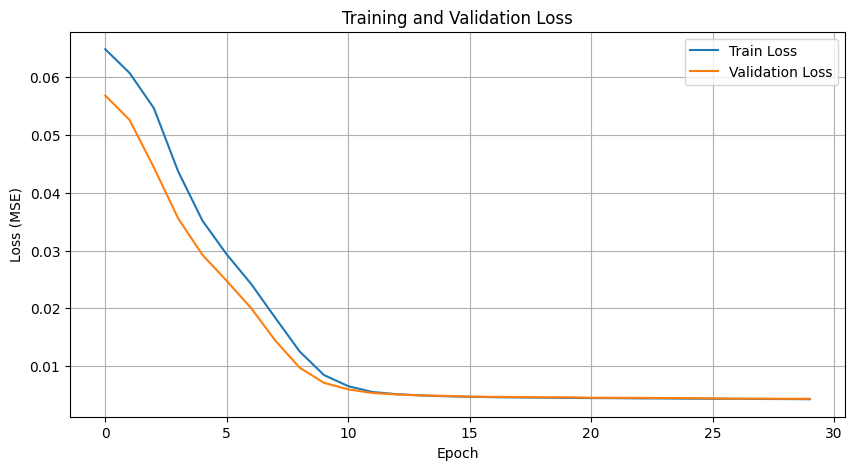

In [355]:
# T2.3b IMPORTANT: Please do not edit/remove this comment.

# Plot the losses in the same figure
plt.figure(figsize=(10, 5))
plt.plot(model.loss_train_log, label='Train Loss')
plt.plot(model.loss_test_log, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid(True)
plt.show()

#### (c) Visualise reconstructed images along with the clean data
    
Visualise some reconstructed images along with clean data and noisy data. You can use the predict function from your trainer. Please plot 20 sets, and make sure label your visualisations appropriately.

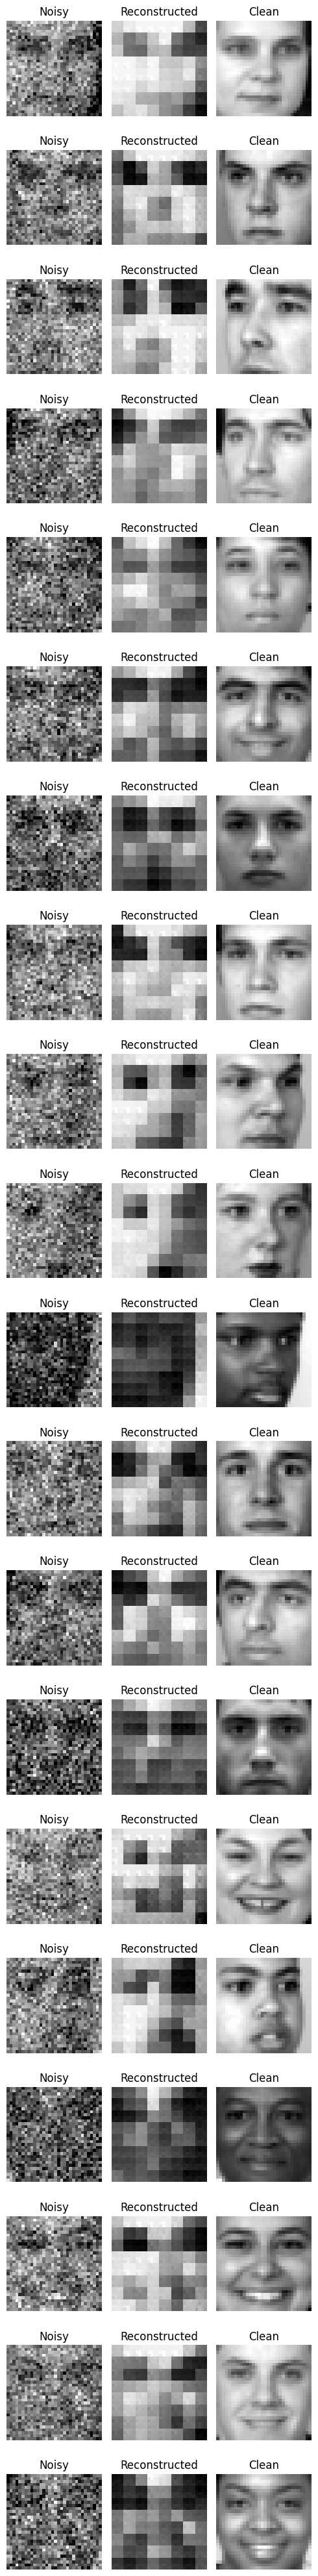

In [356]:
# T2.3c IMPORTANT: Please do not edit/remove this comment.

x_noisy, y_clean, y_recon = model.predict(loader_test)

fig, axes = plt.subplots(20, 3)
fig.set_size_inches(5, 40)

for i in range(20):
    # Column 1: Noisy input
    axes[i, 0].imshow(x_noisy[i][0], cmap='gray')
    axes[i, 0].set_title("Noisy")
    axes[i, 0].axis("off")

    # Column 2: Reconstructed output
    axes[i, 1].imshow(y_recon[i][0], cmap='gray')
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis("off")

    # Column 3: Ground truth
    axes[i, 2].imshow(y_clean[i][0], cmap='gray')
    axes[i, 2].set_title("Clean")
    axes[i, 2].axis("off")

plt.tight_layout()
plt.show()


<div class="alert alert-block alert-info">
    
### Task 2.4: Peak Signal To Noise Ratio (PSNR) <a class="anchor" id="t2_5"></a>
    
Here, you need to Compute Peak Signal-to-Noise Ratio (PSNR) for test dataset. The PSNR is a commonly used metric to measure the quality of a reconstructed or denoised signal or image. The PSNR is calculated as the ratio of the peak signal power to the noise power, typically measured in decibels (dB). PSNR can be defined as </br>
</br>
    $$\mathrm{PSNR} = 10 \cdot \log_{10}\left(\frac{{\mathrm{MAX}^2}}{{\mathrm{MSE}}}\right)$$

Where:

`PSNR` is the Peak Signal-to-Noise Ratio in dB.

`MAX` is the maximum possible pixel value (e.g., 255 for an 8-bit image, or 1 after scaling).

`MSE` is the Mean Squared Error between the original and the reconstructed (or denoised) image. It's calculated as the average of squared pixel-wise differences between the two images.

Show the mean PSNR values for:
- Between the noisy images and original images
- Between the reconstructed images and original images

_Note: there are two mean/average operations here applied separately, one is across the pixels, another is across the images._

In [357]:
# T2.4 IMPORTANT: Please do not edit/remove this comment.

import torch.nn.functional as F

# Compute MSE for each image in batch, then average across all images
def compute_psnr(x, y, max_val=1.0):
    mse = F.mse_loss(x, y, reduction='none')  # shape: (B, 1, 32, 32)
    mse_per_image = mse.view(mse.size(0), -1).mean(dim=1)  # (B,)
    psnr_per_image = 10 * torch.log10(max_val**2 / mse_per_image)
    return psnr_per_image.mean().item()  # scalar

# Get predictions
x_noisy, y_clean, y_recon = model.predict(loader_test)

# Compute PSNR values
psnr_noisy_original = compute_psnr(x_noisy, y_clean)
psnr_recon_original = compute_psnr(y_recon, y_clean)

# Print results
print(f"Mean PSNR value between noisy image and original image: {psnr_noisy_original:.2f}")
print(f"Mean PSNR value between reconstructed image and original image: {psnr_recon_original:.2f}")


Mean PSNR value between noisy image and original image: 16.66
Mean PSNR value between reconstructed image and original image: 23.95


<div class="alert alert-block alert-info">

## Task 3 - Long Short-Term Memory (LSTM) <a class="anchor" id="task3"></a>

In this task, you will be training a LSTM model to predict the power consumption. The details of the dataset are outlined as follows:

- The dataset consists of 5 input features which are used to predict the power consumption of 3 zones (outputs)
- There are a total of 50,000 datapoints. In the `data` folder, you will find `power_train.csv` and `power_test.csv` containing 40,000 training data and 10,000 testing data respectively.
- The following table describes each column entry in the csv file:

| **Column Name**                | **Description**  |
|--------------------------------|------------------|
| Temperature                    | Feature 1        |
| Humidity                       | Feature 2        |
| Wind Speed                     | Feature 3        |
| General Diffuse Flows          | Feature 4        |
| Diffuse Flows                  | Feature 5        |
| Zone 1 Power Consumption	     | Output 1         |
| Zone 2 Power Consumption	     | Output 2         |
| Zone 3 Power Consumption       | Output 3         |

The inputs/features are recorded with sensors on a 10-minute window. It is useful to treat consecutive sensor values as time series, and therefore we are using a LSTM to model their relationship.

In [358]:
# The following code loads the data for this task and stores it as numpy array. Do not modify
data_train = pd.read_csv('data/power_train.csv').to_numpy()
data_test = pd.read_csv('data/power_test.csv').to_numpy()
print(f'Shape of train data: {data_train.shape}')
print(f'Shape of test data: {data_test.shape}')

Shape of train data: (40000, 8)
Shape of test data: (10000, 8)


<div class="alert alert-block alert-info">

### 3.1 Preprocessing of input features

Before we use the data for training, we need to preprocess the data first. If you open and check the csv files, you will see that the features and labels have different range of values. To train deep learning models, it is important to ensure that the values have similar scales for better convergence.

You are required to perform standardization (minus mean and divide by standard deviation).

In [ ]:
# T3.1 IMPORTANT: Please do not edit/remove this comment.

# Find the parameters (mean and std) using np.mean and np.std function.
target_means = np.mean(data_train[:, 5:], axis=0)  # shape: (3,)
target_stds = np.std(data_train[:, 5:], axis=0)    # shape: (3,)

# Step 2: Normalize targets using correct shape
data_train[:, 5:] = (data_train[:, 5:] - target_means) / target_stds
data_test[:, 5:] = (data_test[:, 5:] - target_means) / target_stds

print("data_train[:, 5:].shape:", data_train[:, 5:].shape)
print("target_means.shape:", target_means.shape)
print("Test y mean:", np.mean(data_test[:, 5:], axis=0))
print("Test y std :", np.std(data_test[:, 5:], axis=0))



data_train[:, 5:].shape: (40000, 3)
target_means.shape: (3,)
Test y mean: [ 0.00102865  0.00438744 -0.00262594]
Test y std : [1.00753504 1.008558   0.99797042]


<div class="alert alert-block alert-info">

### 3.2 Define Dataset, Dataloaders, and model

#### (a) Dataset class

In [360]:
# T3.2a IMPORTANT: Please do not edit/remove this comment.

class PowerDataset(Dataset):
    def __init__(self, data, seq_len):
        # For this task, we will treat the data as a sequence of time series data, hence the extra argument "seq_len"
        # Instead of the usual (samples, n_features), you will need to reshape the data to be in the shape of (samples, seq_len, n_features)
        # Another helpful perspective is that each sample is now 2D (seq_len, n_features) instead of 1D (n_features,).
        
        # Separate the inputs and the labels
        x_full = data[:, :5]  # First 5 columns are features
        y_full = data[:, 5:]  # Last 3 columns are targets
        self.seq_len = seq_len

        # Reshape the inputs and labels to be in the shape of (samples, seq_len, n_features)
        self.x_data = []
        self.y_data = []

        for i in range(len(data) - seq_len + 1):
            x_seq = x_full[i:i+seq_len]
            y_seq = y_full[i+seq_len-1]  # Only predict target at the end of sequence
            self.x_data.append(x_seq)
            self.y_data.append(y_seq)

        # Convert to numpy arrays for efficiency
        self.x_data = np.array(self.x_data)
        self.y_data = np.array(self.y_data)

    def __getitem__(self, idx):
        x = torch.from_numpy(self.x_data[idx])  # shape: (seq_len, 5)
        y = torch.from_numpy(self.y_data[idx])  # shape: (3,)
        return x, y

    
    def __len__(self):
        # This function returns the total number of samples in our dataset
        return len(self.x_data)

#### (b) Create Dataset instance from the defined Class and then the DataLoaders

In [361]:
# T3.2b IMPORTANT: Please do not edit/remove this comment.

bs = 64         # the batch size for training task 3
seq_len = 10    # the sequence length for training task 3

# Create an instance of the ConcreteDataset for both the training and test set 
dataset_train = PowerDataset(data_train, seq_len)
dataset_test  = PowerDataset(data_test, seq_len)

# Create dataloaders for both train and test
loader_train = DataLoader(dataset_train, batch_size=bs, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=bs, shuffle=False)

In [ ]:
# T3.2c IMPORTANT: Please do not edit/remove this comment.

class myLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device='cpu'):
        super().__init__()
        self.device = device

        # Define our layers. We will use one LSTM layer with hidden_size followed by a linear layer.
        # Refer the PyTorch documentation for LSTM: https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html
        # Remember to set batch_first=True in the LSTM.
        self.recurrent = nn.LSTM(input_size=input_size,
                                 hidden_size=hidden_size,
                                 batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

        self.to(device=device)

    def forward(self, x):
        # Forward pass through the LSTM layer and then the linear layer
        # No activation function is needed in between.
        # Refer to the LSTM documentation to understand the output of LSTM layer.

        out, _ = self.recurrent(x)  # out: (batch, seq_len, hidden_size)
        out = out[:, -1, :]         # take only the last time step output
        out = self.fc(out)          # (batch, output_size)

        return out
    
    def Train(self, epochs, optimizer, loader_train, loader_test, verbose=True):

        self.loss_train_log = []
        self.loss_test_log = []
        best_loss = np.inf
        criterion = nn.MSELoss()

        for epoch in range(epochs):

            self.train()
            train_loss = 0.0

            for x, y in loader_train:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float)

                optimizer.zero_grad()
                y_hat = self.forward(x)
                loss = criterion(y_hat, y)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * x.size(0)
            
            train_loss /= len(loader_train.dataset)
            self.loss_train_log.append(train_loss)

            val_loss = self.evaluate(loader_test)
            self.loss_test_log.append(val_loss)

            if verbose:
                print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            if val_loss < best_loss:
                best_loss = val_loss
                self.best_model = self.state_dict()

    def evaluate(self, loader):
        
        self.eval()
        criterion = nn.MSELoss()
        
        loss = 0

        with torch.no_grad():
            for x, y in loader:
                x = x.to(device=self.device, dtype=torch.float)
                y = y.to(device=self.device, dtype=torch.float)

                # forward pass and calculate loss
                y_hat = self.forward(x)
                loss += criterion(y_hat, y).item() * x.size(0)
        
        loss /= len(loader.dataset)
        return loss
    
    def predict(self, loader):
        self.eval()

        x_all, y_all, pred = [], [], []
        with torch.no_grad():
            for x, y in loader:
                x_all.append(x)
                y_all.append(y)

                x = x.to(device=self.device, dtype=torch.float)
                y_hat = self.forward(x).cpu()
                pred.append(y_hat)
                
            x_all = torch.cat(x_all, dim=0)
            y_all = torch.cat(y_all, dim=0)
            pred = torch.cat(pred, dim=0)
            
            return x_all, y_all, pred


<div class="alert alert-block alert-info">
    
### Task 3.3: Train your model and evaluate the results

#### (a) Model training

Train your model with the following hyperparameters:
- hidden_size = 32
- Learning rate = \<use one that you think is good\>
- Number of epochs = 40
- Optimizer = Adam
- Weight decay = 1e-5

In [363]:
# T3.3a IMPORTANT: Please do not edit/remove this comment.

lr = 2e-4
epochs = 40

input_size = 5
hidden_size = 32
output_size = 3

model = myLSTM(input_size=input_size, hidden_size=hidden_size, output_size=output_size, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

model.Train(epochs, optimizer, loader_train, loader_test)

Epoch 0 | Train Loss: 0.9173 | Val Loss: 0.8256
Epoch 1 | Train Loss: 0.7983 | Val Loss: 0.7824
Epoch 2 | Train Loss: 0.7741 | Val Loss: 0.7658
Epoch 3 | Train Loss: 0.7611 | Val Loss: 0.7562
Epoch 4 | Train Loss: 0.7520 | Val Loss: 0.7488
Epoch 5 | Train Loss: 0.7454 | Val Loss: 0.7444
Epoch 6 | Train Loss: 0.7403 | Val Loss: 0.7385
Epoch 7 | Train Loss: 0.7356 | Val Loss: 0.7349
Epoch 8 | Train Loss: 0.7314 | Val Loss: 0.7297
Epoch 9 | Train Loss: 0.7269 | Val Loss: 0.7270
Epoch 10 | Train Loss: 0.7231 | Val Loss: 0.7256
Epoch 11 | Train Loss: 0.7197 | Val Loss: 0.7217
Epoch 12 | Train Loss: 0.7164 | Val Loss: 0.7192
Epoch 13 | Train Loss: 0.7136 | Val Loss: 0.7154
Epoch 14 | Train Loss: 0.7109 | Val Loss: 0.7151
Epoch 15 | Train Loss: 0.7088 | Val Loss: 0.7117
Epoch 16 | Train Loss: 0.7066 | Val Loss: 0.7100
Epoch 17 | Train Loss: 0.7044 | Val Loss: 0.7094
Epoch 18 | Train Loss: 0.7024 | Val Loss: 0.7068
Epoch 19 | Train Loss: 0.7010 | Val Loss: 0.7081
Epoch 20 | Train Loss: 0.6987 

#### (b) Inspecting the loss

In the model class, there are two variables `self.loss_train_log` and `self.loss_test_log` which record the historical losses as the training progresses. Plot both the losses in the same figure to visualize the training progress, and ensure that proper labels and legend are in-place.

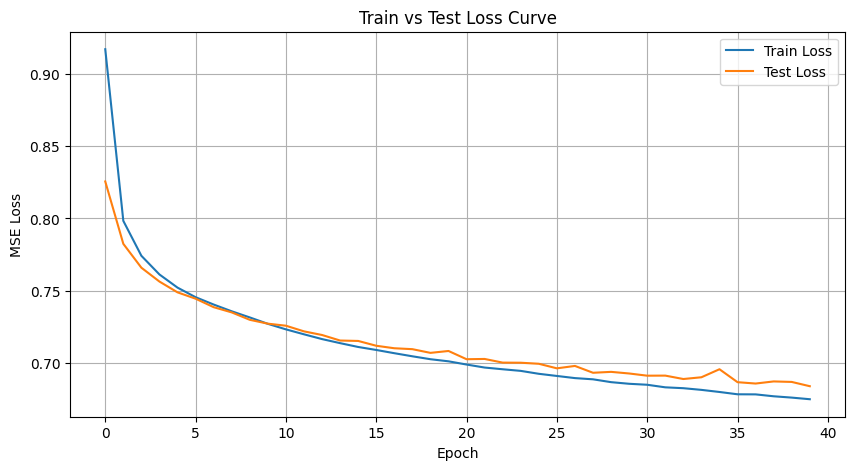

In [364]:
# T3.3b IMPORTANT: Please do not edit/remove this comment.


plt.figure(figsize=(10, 5))
plt.plot(model.loss_train_log, label='Train Loss')
plt.plot(model.loss_test_log, label='Test Loss')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Test Loss Curve")
plt.legend()
plt.grid(True)
plt.show()

#### (c) Visualise prediction along with ground truth
    
Use the `predict` function to obtain the predictions and the ground truth. Reshape both of them back to (samples, 3), and plot the first 50 data points for both of them in the same figure. For simplicity, choose the last output for the plot (since we have 3 outputs).

It is ok if the predictions do not resemble the ground truth, as this is a difficult dataset.

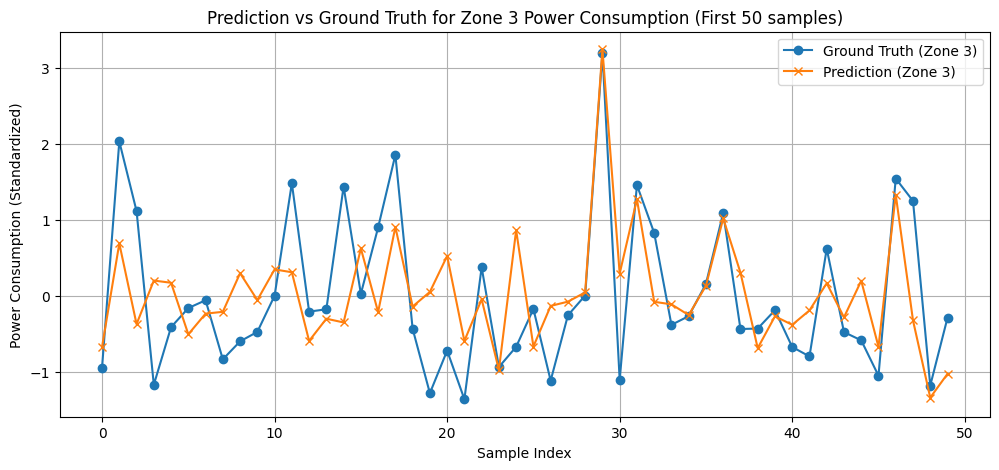

In [365]:
# T3.3c IMPORTANT: Please do not edit/remove this comment.

# Get predictions
x_all, y_all, pred = model.predict(loader_test)

# Convert to tensors (if they aren't already)
y_all = y_all.numpy() if hasattr(y_all, 'numpy') else y_all
pred = pred.numpy() if hasattr(pred, 'numpy') else pred

# Plot only the third output (index 2) — for the first 50 samples
plt.figure(figsize=(12, 5))
plt.plot(y_all[:50, 2], label='Ground Truth (Zone 3)', marker='o')
plt.plot(pred[:50, 2], label='Prediction (Zone 3)', marker='x')
plt.title("Prediction vs Ground Truth for Zone 3 Power Consumption (First 50 samples)")
plt.xlabel("Sample Index")
plt.ylabel("Power Consumption (Standardized)")
plt.legend()
plt.grid(True)
plt.show()

<div class="alert alert-block alert-info">

## Task 4 - Movie Review Sentiment Analysis Using Pre-Trained Language Model (Transformer) <a class="anchor" id="task4"></a>

In this task, we will explore how to use a pretrained transformer-based language model to build a simple sentiment classifier for movie reviews. Transformer models are powerful tools that have dramatically improved the performance of natural language processing tasks. You may have heard BERT and GPT, which are trained on massive datasets and capable of understanding complex language patterns. However, training such models from scratch is computationally expensive and typically requires large-scale data and infrastructure, making it impractical for most applications.

Instead, we will use a **pretrained transformer** to extract rich textual features from input reviews and feed these features into a MLP, which we will finetune to be our classifier. This MLP will take the encoded representation of a movie review and predict whether the sentiment is positive or negative.

#### (a) Choosing and Loading a Pretrained Model

To begin, we need to select a suitable pretrained model. [Hugging Face](https://huggingface.co/models) is an open-source library that provides access to a large collection of pretrained models optimized for various tasks. For our purposes, we will use the pretrained model known as `distilbert-base-uncased`, a smaller and faster version of BERT that maintains good performance while being efficient enough for classroom use. Along with the model, we also load its corresponding tokenizer.

A tokenizer is responsible for converting raw text into numerical tokens that the model can understand. Each pretrained language model comes with its own tokenizer because the way text is split into tokens (e.g., words, subwords) and mapped to numerical IDs is tightly coupled with how the model was originally trained. Using the correct tokenizer ensures that the input is processed in the exact same way as during pretraining, preserving performance and compatibility.

You can use `AutoModel` and `AutoTokenizer` (already imported for you) and to load the model and tokenizer respectively.

In [366]:
# T4a IMPORTANT: Please do not edit/remove this comment.

pretrained_model_name = "distilbert-base-uncased"

tokenizer = AutoTokenizer.from_pretrained(pretrained_model_name)
transformer_model = AutoModel.from_pretrained(pretrained_model_name)

print(transformer_model.config)

DistilBertConfig {
  "_attn_implementation_autoset": true,
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.49.0",
  "vocab_size": 30522
}



#### (b) Dataset class

In [368]:
# T4b IMPORTANT: Please do not edit/remove this comment.

class ReviewDataset(Dataset):
    def __init__(self, csv_file, tokenizer, max_length=128):
        # read the csv file and load the data using pandas
        # Make sure to convert the labels to integers (0 or 1) corresponding to the sentiment (negative or positive)
        df = pd.read_csv(csv_file)
        self.texts = df["review"].tolist()
        self.labels = df["sentiment"].map({"negative": 0, "positive": 1}).tolist()
        
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx] # should be texts/string
        label = self.labels[idx] # should be a integer 0 or 1

        # Tokenize the text and convert to input IDs and attention masks
        # Specify truncation, max_length, and padding options, such that the tokenizer will either truncate or pad the text to the specified max_length.
        # Note: The tokenizer will automatically add the [CLS] and [SEP] tokens for you.
        # The purpose of the attention mask is to tell the model which tokens are padding and which are not.
        inputs = self.tokenizer(text,
            truncation=True,
            padding='max_length',
            max_length=self.max_length,
            return_tensors="pt"
        )
        
        # Ensure that the returned variables have the correct shapes.
        # They should all be 1-dimensional tensors (either max_length or 1)
        # Use function like view/reshape or squeeze/unsqueeze to adjust the shapes.
        # Also make sure all of them are converted to tensor object.
        input_ids = inputs["input_ids"].squeeze(0)         # shape: (max_length,)
        attention_mask = inputs["attention_mask"].squeeze(0)  # shape: (max_length,)
        label = torch.tensor(label).long()                  # shape: ()

        return input_ids, attention_mask, label

#### (c) Create Dataset instances and Dataloaders

In [369]:
# T4c IMPORTANT: Please do not edit/remove this comment.

max_length = 128 # From the model config, the max length for this model is 512. However, we will set it to 64 so that the model can train faster.
batch_size = 32

dataset_train = ReviewDataset("data/movie_train.csv", tokenizer, max_length=max_length)
dataset_test = ReviewDataset("data/movie_test.csv", tokenizer, max_length=max_length)

loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

#### (d) Model class

In [ ]:
# T4d IMPORTANT: Please do not edit/remove this comment.

class SentimentClassifier(nn.Module):
    def __init__(self, transformer, hidden_dim, device='cpu'):
        super().__init__()
        self.device = device
        
        self.transformer = transformer
        transformer_output_dim = transformer.config.hidden_size

        # We are using the transformer model as a feature extractor, not training it
        # We can prevent the transformer model from being trained by setting requires_grad to False (freezing the weights)
        for param in self.transformer.parameters():
            param.requires_grad = False

        # Define a simple feedforward neural network (MLP) for classification
        # The layers should be Linear (with output as hidden_dim) -> ReLU -> Linear (with output as 1) -> Sigmoid
        self.classifier = nn.Sequential(
            nn.Linear(transformer_output_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

        self.to(device=device)

    def forward(self, input_ids, attention_mask):
        # Forward pass through the transformer model and then the classifier
        # The transformer takes in two inputs: input_ids and attention_mask
        # After the transformer, we need to extract the CLS token output (the first token in the sequence) and pass it through the classifier
        # You can access the transformer output using out.last_hidden_state
        output = self.transformer(input_ids=input_ids, attention_mask=attention_mask)
        cls_token = output.last_hidden_state[:, 0, :]  # CLS token embedding
        out = self.classifier(cls_token)
        return out.squeeze(1)  # shape: (batch_size,)
    

    def Train(self, epochs, optimizer, loader_train, loader_test, verbose=True):

        self.loss_train_log = []
        self.loss_test_log = []
        best_loss = np.inf

        criterion = nn.BCELoss() 

        for epoch in range(epochs):
            self.train()
            train_loss = 0.0

            # Step (1)        
            for input_ids, attention_mask, labels in loader_train:
                # Cast the input_ids and attention_mask to torch.long
                # Cast the label to torch.float (although this is classification, we need to cast y to float because of the loss function that you will use later)
                
                input_ids = input_ids.to(self.device, dtype=torch.long)
                attention_mask = attention_mask.to(self.device, dtype=torch.long)
                labels = labels.to(self.device, dtype=torch.float)

                optimizer.zero_grad()
                y_hat = self.forward(input_ids, attention_mask)
                loss = criterion(y_hat, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item() * input_ids.size(0)
            
            train_loss /= len(loader_train.dataset)
            self.loss_train_log.append(train_loss)

            val_loss = self.evaluate(loader_test)
            self.loss_test_log.append(val_loss)

            if verbose:
                print(f"Epoch {epoch} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

            if val_loss < best_loss:
                best_loss = val_loss
                self.best_model = self.state_dict()
        

    def evaluate(self, loader):
        self.eval()
        criterion = nn.BCELoss()
        loss = 0

        with torch.no_grad():
            for input_ids, attention_mask, labels in loader:

                input_ids = input_ids.to(self.device, dtype=torch.long)
                attention_mask = attention_mask.to(self.device, dtype=torch.long)
                labels = labels.to(self.device, dtype=torch.float)

                # forward pass and calculate loss
                y_hat = self.forward(input_ids, attention_mask)
                loss += criterion(y_hat, labels).item() * input_ids.size(0)
        
        loss /= len(loader.dataset)
        return loss
    
    def predict(self, loader):
        self.eval()

        x_all, y_all, pred = [], [], []
        with torch.no_grad():

            for input_ids, attention_mask, labels in loader:
                input_ids = input_ids.to(self.device, dtype=torch.long)
                attention_mask = attention_mask.to(self.device, dtype=torch.long)

                y_hat = self.forward(input_ids, attention_mask).cpu()
                x_all.append(input_ids.cpu())
                labels = labels.to(self.device)
                y_all.append(labels.cpu())
                pred.append(y_hat)

            x_all = torch.cat(x_all, dim=0)
            y_all = torch.cat(y_all, dim=0)
            pred = torch.cat(pred, dim=0)
                
            return x_all, y_all, pred

#### (a) Model training

Train your model with the following hyperparameters:
- Learning rate = 0.001
- Number of epochs = 5 (we will just train for 5 epochs because transformer is computationally heavy, and it will take a long time)
- Optimizer = Adam

In [371]:
# T4e IMPORTANT: Please do not edit/remove this comment.
lr = 0.001
epochs = 20
hidden_dim = 128

model = SentimentClassifier(transformer_model, hidden_dim=hidden_dim, device=device)
optimizer = optim.Adam(model.parameters(), lr=lr)

model.Train(epochs, optimizer, loader_train, loader_test)

Epoch 0 | Train Loss: 0.6804 | Val Loss: 0.6441
Epoch 1 | Train Loss: 0.6143 | Val Loss: 0.6015
Epoch 2 | Train Loss: 0.5802 | Val Loss: 0.5698
Epoch 3 | Train Loss: 0.5091 | Val Loss: 0.5847
Epoch 4 | Train Loss: 0.4849 | Val Loss: 0.5454
Epoch 5 | Train Loss: 0.4626 | Val Loss: 0.5286
Epoch 6 | Train Loss: 0.4611 | Val Loss: 0.5666
Epoch 7 | Train Loss: 0.4270 | Val Loss: 0.5241
Epoch 8 | Train Loss: 0.4248 | Val Loss: 0.5307
Epoch 9 | Train Loss: 0.4233 | Val Loss: 0.5029
Epoch 10 | Train Loss: 0.4040 | Val Loss: 0.5109
Epoch 11 | Train Loss: 0.3949 | Val Loss: 0.4901
Epoch 12 | Train Loss: 0.3742 | Val Loss: 0.5214
Epoch 13 | Train Loss: 0.3801 | Val Loss: 0.4995
Epoch 14 | Train Loss: 0.3666 | Val Loss: 0.5153
Epoch 15 | Train Loss: 0.3872 | Val Loss: 0.5125
Epoch 16 | Train Loss: 0.3544 | Val Loss: 0.5137
Epoch 17 | Train Loss: 0.3448 | Val Loss: 0.5089
Epoch 18 | Train Loss: 0.3362 | Val Loss: 0.4924
Epoch 19 | Train Loss: 0.3362 | Val Loss: 0.4918


#### (f) Evaluate accuracy on test dataset

In [372]:
# T4f IMPORTANT: Please do not edit/remove this comment.

x_all, y_all, pred = model.predict(loader_test)
# Convert predicted probabilities to binary labels (0 or 1)
pred_labels = (pred >= 0.5).int()

# Compute accuracy
correct = (pred_labels == y_all.int()).sum().item()
accuracy = correct / len(y_all)

print(accuracy)

0.75


#### Test on your own prompt!

In [373]:
prompt = "Absolute cinema"
inputs = tokenizer(prompt, truncation=True, padding='max_length', max_length=64, return_tensors="pt")

with torch.no_grad():
    model.eval()
    input_ids = inputs["input_ids"].to(model.device)
    attention_mask = inputs["attention_mask"].to(model.device)
    
    pred = model.forward(input_ids, attention_mask)

print(pred.item() )
if pred.item() > 0.5:
    print("Positive sentiment")
else:
    print("Negative sentiment")

# for name, param in model.named_parameters():
#     print(f"{name}: {param.requires_grad}")

0.9543522000312805
Positive sentiment


<div class="alert alert-block alert-info">

## Task 5 - Design Your Own Regression Model <a class="anchor" id="task5"></a>
        
In this task, you will design and train a model for a regression problem. The task is to predict a variable (output) given a list other variables (input). There will be no guidance, and you should use the knowledge obtained thus far to complete this task.

The dataset that you will be using is located in `data/task5_train.csv`. It has a total of 23 columns: the first 22 columns are the inputs, and the final column is variable we wish to predict. The name of the variables are removed, but the values are sensor readings obtained from a facility/process, at a sampling rate of 1 Hz.

**READ** the following instructions carefully to understand how this task will be graded:

- You are free to design and explore whatever methods/layers/techniques you want.
- In the end, you are required to produce a model that you think is best, and named it as `task5_best_params.pt`. Use exactly this file name and there is no need to rename it.
- You will submit this `.pt` file, together with this notebook (`.ipynb`), in the Assignment Submission. Do **NOT** zip your submission.
- For grading, I will run your submitted model using a private test dataset (not given to you), and evaluate your model performance.
- In order to run your model, I have to instantiate your model class, i.e. `Task5_Model`. Therefore, make sure all your model code are in this class, and in the cell commented with  "**# T5(model) ...**".
- As a check, there is a cell at the end of this task which you can run to make sure that your submission will be ok. In this cell, your best model will be used to run a few sample test data located in `data/task5_sample_test`. Make sure this cell can run without error before you submit the files.

How this task is graded (worth 3%):
- 1.5% will be awarded if your model can be executed successfully.
- 1.5% will be awarded in a linear fashion (0 to 1.5) based on everyone's MSE on the private test data (i.e. if your MSE is the best among all, you get 1.5m, 0m is your MSE is the worst, and everyone else is linearly interpolated in between).

Final notes:
- Your submitted model will be checked for similarity. If your model happens to have the same weight values with others, which is statistically impossible, it will be marked as plagiarism.
- If your training code (with your final hyperparameters) is run with the given dataset, the trained model should have similar performance to the one that you submit. If the difference is large, you will be questioned and asked to resubmit a new one in the presence of a demonstrator.

Good luck !

In [12]:
class Task5Dataset(Dataset):
    def __init__(self, X, y):
        self.X = X.astype(np.float32)
        self.y = y.astype(np.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float32).unsqueeze(0)
        y = torch.tensor(self.y[idx], dtype=torch.float32)
        return x, y

In [3]:
# T5(model) IMPORTANT: Please do not edit/remove this comment.

class Task5_Model(nn.Module):
    def __init__(self, input_size=22, hidden_dim=128, num_layers=1, device='cpu', bidir=False):

        super(Task5_Model, self).__init__()
        self.device = device
    
        self.lstm = nn.LSTM(input_size=input_size,
                            hidden_size=hidden_dim,
                            num_layers=num_layers,
                            batch_first=True,
                            bidirectional=bidir)
        
        self.lstm_out_dim = hidden_dim * 2 if bidir else hidden_dim
        # self.norm = nn.LayerNorm(self.lstm_out_dim)

        self.regressor = nn.Sequential(
            nn.Linear(self.lstm_out_dim, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

        self.to(device)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)  # hn shape: [1, batch, hidden_dim] for unidirectional 1-layer
        last_hidden = hn[-1]       # shape: [batch, hidden_dim]
        return self.regressor(last_hidden).squeeze(-1)  # shape: [batch]

    def Train(self, epochs, optimizer, loader_train, loader_val, verbose=True):
        self.loss_train_log = []
        self.loss_val_log = []
        best_loss = np.inf

        criterion = nn.MSELoss()
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                         mode='min', 
                                                         factor=0.5, 
                                                         patience=6, 
                                                         threshold=0, 
                                                         min_lr=1e-6,
                                                         threshold_mode='abs')

        for epoch in range(epochs):
            self.train()
            total_train_loss = 0.0

            for x, y in loader_train:
                x = x.to(self.device)
                y = y.to(self.device)

                optimizer.zero_grad()
                y_pred = self.forward(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item() * x.size(0)

            avg_train_loss = total_train_loss / len(loader_train.dataset)
            self.loss_train_log.append(avg_train_loss)

            val_loss = self.evaluate(loader_val)
            self.loss_val_log.append(val_loss)
            scheduler.step(val_loss)

            if verbose:
                current_lr = optimizer.param_groups[0]['lr']
                print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.10f} | Val Loss: {val_loss:.10f} | LR: {current_lr:.6e}")

            if val_loss < best_loss:
                best_loss = val_loss
                self.best_model = self.state_dict()
                torch.save(self.best_model, "task5_best_params.pt") 
        
        print(">-----------------------------------------------------------------<")
        print(f"Best model saved at epoch {np.argmin(self.loss_val_log)} | Train Loss: {self.loss_train_log[np.argmin(self.loss_val_log)]:.10f} | Val Loss: {min(self.loss_val_log):.10f}")
        print(">-----------------------------------------------------------------<")

    def evaluate(self, loader):
        self.eval()
        criterion = nn.MSELoss()
        total_loss = 0.0

        with torch.no_grad():
            for x, y in loader:
                x = x.to(self.device)
                y = y.to(self.device)

                y_pred = self.forward(x)
                total_loss += criterion(y_pred, y).item() * x.size(0)

        return total_loss / len(loader.dataset)

    def predict(self, loader):
        self.eval()
        x_all, y_all, pred_all = [], [], []

        # === Hardcoded mean and std from training set ===
        # y_mean = 0.10004447     # old
        # y_std = 0.0015721702    # old

        y_mean = 0.100027494     # new
        y_std = 0.0016103466    # new

        with torch.no_grad():

            for x, y in loader:
                x = x.to(self.device)
                y_pred_std = self.forward(x).cpu()

                y = y * y_std + y_mean
                y_pred = y_pred_std * y_std + y_mean

                x_all.append(x.cpu())
                y_all.append(y.cpu())
                pred_all.append(y_pred)

        return (
            torch.cat(x_all, dim=0),
            torch.cat(y_all, dim=0),
            torch.cat(pred_all, dim=0)
        )

    def deploy(self, input_array: np.ndarray) -> np.ndarray:
        self.eval()

        # === Hardcoded normalization values from training ===
        y_mean = 0.10002549
        y_std  = 0.0016073846

        X_mean = torch.tensor([
            1.3940264e-01, 1.3393687e-01, 1.0158686e-01, 1.0391240e-01, 3.2349408e-02,
            3.8304311e-01, 3.1206217e-02, 2.6228657e+00, 7.7822711e-03, 9.0613848e-01,
            5.3394556e-01, 7.2162514e+01, 8.3988477e+02, 9.9816833e+02, 1.9873215e+01,
            1.9726540e+01, 1.9448040e+01, 2.8084293e+01, 2.4115774e+01, 6.6044273e+01,
            4.8988049e+01, 2.2305253e+00
        ], dtype=torch.float32).to(self.device)

        X_std = torch.tensor([
            1.2570411e-02, 1.2486641e-02, 2.2339509e-03, 2.2939786e-03, 1.2898387e-02,
            2.2485864e-01, 8.3908197e-03, 1.9436904e+00, 4.5400667e-01, 1.2643251e-01,
            5.9206241e-01, 3.8231895e+01, 2.3898526e+02, 1.1739938e+00, 3.8007364e+00,
            3.6719713e+00, 3.7462974e+00, 6.3956990e+00, 2.3325441e+00, 1.7215950e+01,
            1.8912659e+01, 1.3665663e-01
        ], dtype=torch.float32).to(self.device)

        # === Convert and normalize input ===
        x_tensor = torch.tensor(input_array, dtype=torch.float32).to(self.device)
        x_tensor = (x_tensor - X_mean) / X_std  # Standardize X

        if x_tensor.ndim == 2:
            x_tensor = x_tensor.unsqueeze(1)  # [batch, 1, 22]

        # === Predict ===
        with torch.no_grad():
            y_pred_std = self.forward(x_tensor).cpu()

        # === Unstandardize prediction ===
        y_pred = (y_pred_std * y_std) + y_mean

        return y_pred.numpy().reshape(-1, 1)  # shape: (num_samples, 1)



In [13]:
# Load raw data from CSV
t5_data_train = pd.read_csv("data/task5_train.csv").astype(np.float32)
t5_data_test = pd.read_csv("data/task5_sample_test.csv").astype(np.float32)
t5_X_train_raw = t5_data_train.iloc[:, :-1].values
t5_y_train_raw = t5_data_train.iloc[:, -1].values


# Split training data
t5_X_train_raw, t5_X_val_raw, t5_y_train_raw, t5_y_val_raw = train_test_split(
    t5_X_train_raw, t5_y_train_raw, test_size=0.1,shuffle=True, random_state=42)

# Normalise Y
t5_y_mean = t5_y_train_raw.mean()
t5_y_std = t5_y_train_raw.std()
print(t5_y_mean, t5_y_std)
t5_y_train = (t5_y_train_raw - t5_y_mean) / t5_y_std
t5_y_val   = (t5_y_val_raw   - t5_y_mean) / t5_y_std

# Normalize X
t5_X_mean = t5_X_train_raw.mean(axis=0)  # shape: (22,)
t5_X_std  = t5_X_train_raw.std(axis=0)   # shape: (22,)
print(t5_X_mean)
print(t5_X_std)
t5_X_train = (t5_X_train_raw - t5_X_mean) / t5_X_std
t5_X_val   = (t5_X_val_raw   - t5_X_mean) / t5_X_std


# Create train and val datasets & loaders
t5_train_dataset = Task5Dataset(t5_X_train, t5_y_train)
t5_val_dataset   = Task5Dataset(t5_X_val,   t5_y_val)
t5_train_loader = DataLoader(t5_train_dataset, batch_size=64, shuffle=True)
t5_val_loader   = DataLoader(t5_val_dataset,   batch_size=64, shuffle=False)

for x, y in t5_train_loader:
    print(f"Batch shape: {x.shape}")  # Should be [batch_size, 22, 1]
    print("Sample y:", y[:5])
    break


0.100027494 0.0016103466
[1.3940264e-01 1.3393687e-01 1.0158686e-01 1.0391240e-01 3.2349408e-02
 3.8304311e-01 3.1206217e-02 2.6228657e+00 7.7822711e-03 9.0613848e-01
 5.3394556e-01 7.2162514e+01 8.3988477e+02 9.9816833e+02 1.9873215e+01
 1.9726540e+01 1.9448040e+01 2.8084293e+01 2.4115774e+01 6.6044273e+01
 4.8988049e+01 2.2305253e+00]
[1.2570411e-02 1.2486641e-02 2.2339509e-03 2.2939786e-03 1.2898387e-02
 2.2485864e-01 8.3908197e-03 1.9436904e+00 4.5400667e-01 1.2643251e-01
 5.9206241e-01 3.8231895e+01 2.3898526e+02 1.1739938e+00 3.8007364e+00
 3.6719713e+00 3.7462974e+00 6.3956990e+00 2.3325441e+00 1.7215950e+01
 1.8912659e+01 1.3665663e-01]
Batch shape: torch.Size([64, 1, 22])
Sample y: tensor([0.2832, 0.0442, 0.5329, 2.6791, 0.5699])


In [519]:
model = Task5_Model(device=device)
model.to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

model.Train(
    epochs=300,
    optimizer=optimizer,
    loader_train=t5_train_loader,
    loader_val=t5_val_loader,
    verbose=True
)

Epoch 0 | Train Loss: 0.7121155106 | Val Loss: 0.2042304659 | LR: 1.000000e-04
Epoch 1 | Train Loss: 0.1986776839 | Val Loss: 0.1280917382 | LR: 1.000000e-04
Epoch 2 | Train Loss: 0.1580237831 | Val Loss: 0.1046416373 | LR: 1.000000e-04
Epoch 3 | Train Loss: 0.1323585315 | Val Loss: 0.0934004518 | LR: 1.000000e-04
Epoch 4 | Train Loss: 0.1165671230 | Val Loss: 0.0823350895 | LR: 1.000000e-04
Epoch 5 | Train Loss: 0.1058578224 | Val Loss: 0.0742019452 | LR: 1.000000e-04
Epoch 6 | Train Loss: 0.0961521326 | Val Loss: 0.0682090609 | LR: 1.000000e-04
Epoch 7 | Train Loss: 0.0899360370 | Val Loss: 0.0633092788 | LR: 1.000000e-04
Epoch 8 | Train Loss: 0.0845469894 | Val Loss: 0.0601519357 | LR: 1.000000e-04
Epoch 9 | Train Loss: 0.0816222079 | Val Loss: 0.0571316672 | LR: 1.000000e-04
Epoch 10 | Train Loss: 0.0789679398 | Val Loss: 0.0551750724 | LR: 1.000000e-04
Epoch 11 | Train Loss: 0.0751887946 | Val Loss: 0.0524915594 | LR: 1.000000e-04
Epoch 12 | Train Loss: 0.0732872712 | Val Loss: 0.

In [14]:
# Load model
task5_best_params = torch.load('task5_best_params.pt', map_location=device)
model_best = Task5_Model(device=device)
model_best.load_state_dict(task5_best_params)

# Predict
final_data_test = pd.read_csv("data/task5_sample_test.csv").astype(np.float32)
final_test_loader = DataLoader(final_data_test, batch_size=64, shuffle=False)
x_test, y_test, y_pred= model_best.predict(t5_val_loader)

# === Compute MSE ===
mse = mean_squared_error(y_test, y_pred)
print(f"Final Test MSE: {mse:.8f}")

Final Test MSE: 0.00000004


In [15]:
task5_best_params = torch.load('task5_best_params.pt', map_location=device)
model_best = Task5_Model(device=device)
model_best.load_state_dict(task5_best_params)

y_pred = model_best.deploy(t5_X_val_raw)
mse = mean_squared_error(t5_y_val_raw, y_pred)
print(f"Final Test MSE: {mse:.8f}")

Final Test MSE: 0.00000004


In [9]:
# For this task to be graded, make sure this cell can run without error and without modification
# You should restart the kernel, run the first import cell, run the Task5_Model class, and then run this cell.

# IMPORTANT: In your Task5_Model class, create a new method called "deploy" that takes in only one argument.
# This method should take as input a numpy array of shape (num_samples, 22) and return a numpy array of shape (num_samples, 1).
# Inside the method, you should do all the necessary preprocessing (e.g. standardize, convert to tensor, etc.) before passing it to the model
# Since the method does not allow other arguments, you may have to hardcode some values (e.g. means, stds) inside the method. Do not assume global variables are available.
# Note that the final MSE is calculated based on the ground truth's original scale (i.e. not the standardized scale).
# Therefore, for your prediction, make sure to UN-standardize the prediction before returning it. Failure to do so will result in a very high MSE.


# The sample test data is already loaded for you here. It is a numpy array of shape (11, 22). Last column is removed.
# When grading, I will replace this with the private test data, which has shape (???, 22). ? can be any integer, and may not be a "nice" integer such as those divisible by 5 or 10.
test_data = pd.read_csv('data/task5_sample_test.csv').to_numpy()[:, :-1]
# test_data = np.random.randn(999, 22) # for testing purposes. Your model should be able to handle any number of samples.
task5_best_params = torch.load('task5_best_params.pt', map_location=device)
model_best = Task5_Model(device=device)
model_best.load_state_dict(task5_best_params)
pred = model_best.deploy(test_data)
print(f'Prediction shape: {pred.shape}') # should be (num_samples, 1)

Prediction shape: (11, 1)
